<a href="https://colab.research.google.com/github/matbest/StockTensorTimeSeries/blob/master/new%20file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install stockstats

         time      low     high  ...    close     volume           local_time
0  1577836800  7151.92  7165.72  ...  7155.00  41.313098  2020-01-01 00:00:00
1  1577837100  7136.05  7161.73  ...  7161.70  94.463537  2020-01-01 00:05:00
2  1577837400  7156.63  7163.62  ...  7158.23   9.035745  2020-01-01 00:10:00
3  1577837700  7154.20  7159.77  ...  7155.03   6.328524  2020-01-01 00:15:00
4  1577838000  7151.60  7157.21  ...  7154.48  12.006777  2020-01-01 00:20:00

[5 rows x 7 columns]
         time      low     high  ...    close     volume           local_time
0  1577836800  7151.92  7165.72  ...  7155.00  41.313098  2020-01-01 00:00:00
1  1577837100  7136.05  7161.73  ...  7161.70  94.463537  2020-01-01 00:05:00
2  1577837400  7156.63  7163.62  ...  7158.23   9.035745  2020-01-01 00:10:00
3  1577837700  7154.20  7159.77  ...  7155.03   6.328524  2020-01-01 00:15:00
4  1577838000  7151.60  7157.21  ...  7154.48  12.006777  2020-01-01 00:20:00

[5 rows x 7 columns]


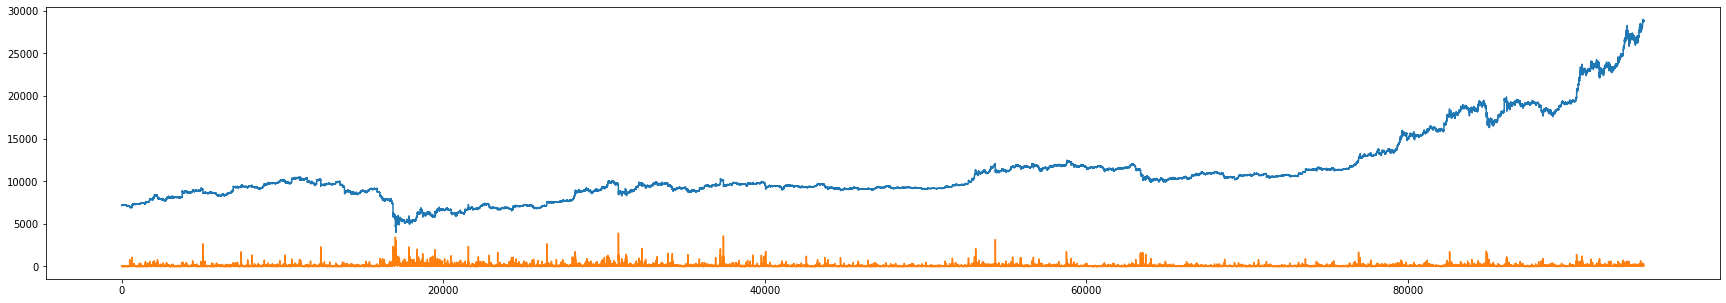

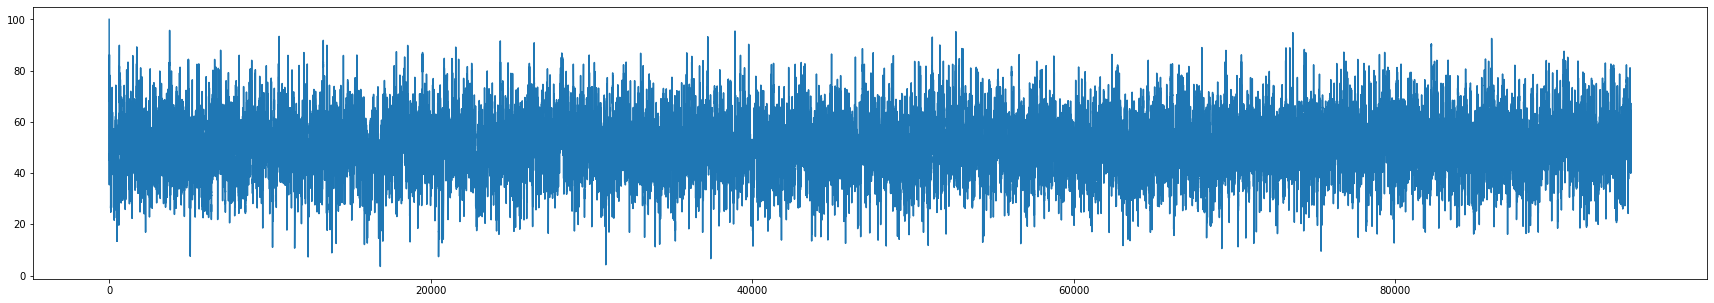

In [50]:

import pandas as pd
from stockstats import StockDataFrame as Sdf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import datetime

#original_data = pd.read_csv("2020_V1.csv"
#Click on the dataset in your repository, then click on View Raw. 
url = 'https://raw.githubusercontent.com/matbest/StockTensorTimeSeries/master/Data/Input/2020_V1.csv'
original_data = pd.read_csv(url)

#original_data.dropna()
stock = Sdf.retype(original_data)

print(original_data.head())

#original_data.dropna()
original_data.drop(columns=original_data.columns[6])
#original_data = original_data.apply(pd.to_numeric, errors='coerce')
#original_data = original_data.dropna()

print(original_data.head())

#data.hist()
plt.figure(figsize=(30,5))
plt.plot(original_data['open'])
plt.plot(original_data['volume'])
plt.show()
plt.figure(figsize=(30,5))
plt.plot(stock['rsi_14'])
plt.show()

In [44]:

print(original_data.head())


         time      low     high  ...  closenm_14_smma     rs_14      rsi_14
0  1577836800  7151.92  7165.72  ...              NaN       NaN         NaN
1  1577837100  7136.05  7161.73  ...         0.000000       inf  100.000000
2  1577837400  7156.63  7163.62  ...         1.799259  1.792919   64.195165
3  1577837700  7154.20  7159.77  ...         2.301170  0.899550   47.355962
4  1577838000  7151.60  7157.21  ...         1.813579  0.823591   45.163153

[5 rows x 15 columns]


KeyError: ignored

# Moving average forecast

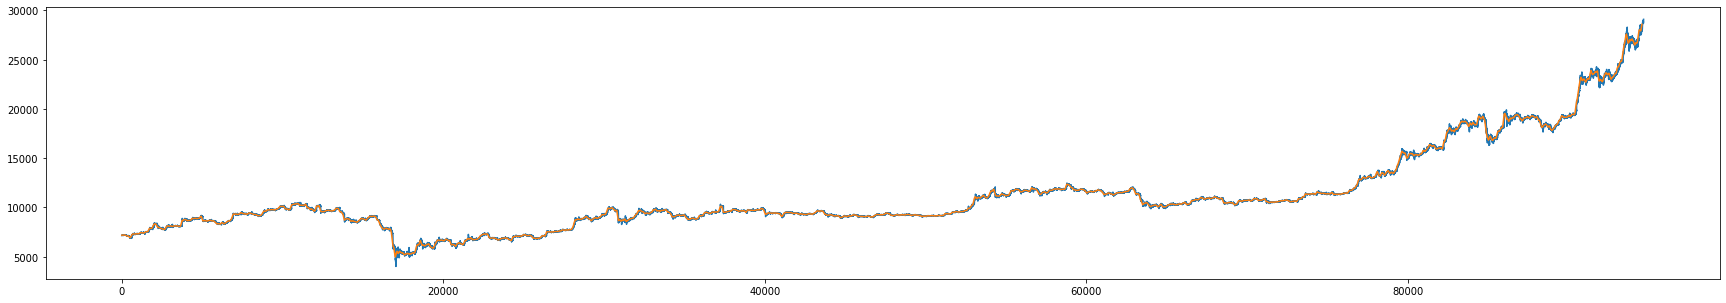

18793.831106416532
81.87261798295697


In [7]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

series = original_data['close']
window = 100
moving_avg = moving_average_forecast(original_data['close'], window)
plt.figure(figsize=(30,5))
series.plot()

plt.plot(moving_avg)
plt.show()

print(keras.metrics.mean_squared_error(series[:-window], moving_avg).numpy())
print(keras.metrics.mean_absolute_error(series[:-window], moving_avg).numpy())

In [8]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16969981193560907433
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14674281152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 669584665028129583
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [9]:

!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
import string
from subprocess import run
print( run(['nvidia-smi'], capture_output=True, text=True).stdout.replace('\\n', '\n').replace('\\t', '\t'))


Fri Mar 12 19:49:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    28W /  70W |    230MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Deep Neural Networks (DNN) one layer, linear regression

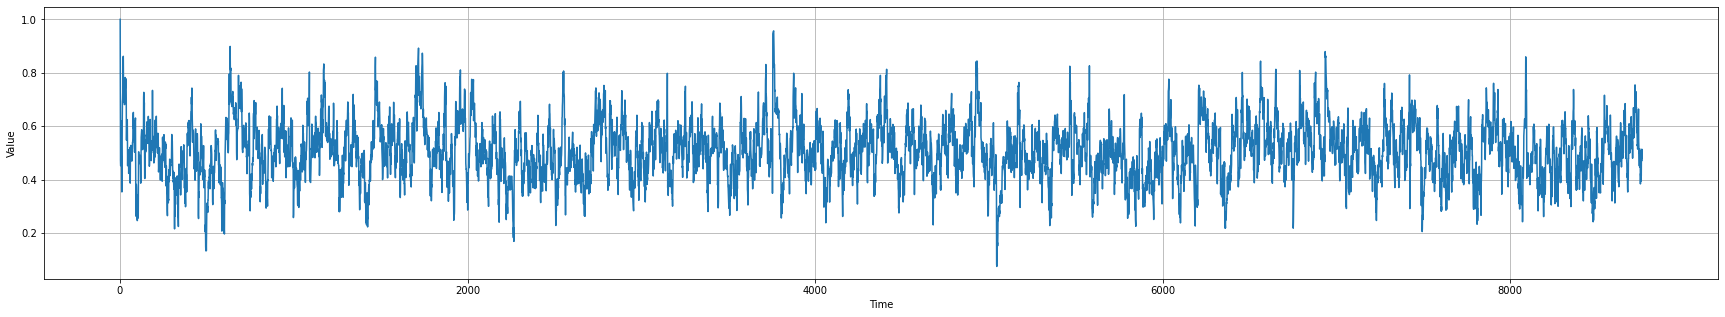

In [10]:
sampleMonth = 8760
#data = original_data['close'].head(sampleMonth * 2).to_numpy()
data =stock['rsi_14'].head(sampleMonth * 2).to_numpy()/100 # Work with RSI rather than raw numbers, and place between 0 to 1.

time = np.arange(sampleMonth * 2, dtype="float32")

split_time = sampleMonth

time_train = time[:split_time]
x_train = data[:split_time]

time_valid = time[split_time:]
x_valid = data[split_time:]

def plot_series(time, series, format="-", start=0, end=None):
    plt.figure(figsize=(30,5))
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


plot_series(time_train, x_train)

window_size = int(sampleMonth * 0.014)
batch_size = int(sampleMonth * 0.022)
shuffle_buffer_size = split_time

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def data_summary(train):
    """Summarize current state of dataset"""
    print('Train  shape:', train.shape)

In [12]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 123       
Total params: 123
Trainable params: 123
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.fit?

In [14]:
print("Layer weights {}".format(l0.get_weights()))

#model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=0.000055,  momentum=0.010, nesterov=True))
#model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.0,  clipvalue=1.))
#model.fit(dataset,epochs=10,verbose=1)


model.compile(optimizer='sgd', loss='mse')
# This builds the model for the first time:
#model.fit(x, y, batch_size=32, epochs=10,verbose=1)
model.fit(dataset,epochs=10,verbose=1)


print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[ 0.05502714],
       [ 0.14315791],
       [ 0.21283706],
       [ 0.11659096],
       [-0.21656965],
       [-0.12293129],
       [ 0.06685726],
       [ 0.08829994],
       [-0.00886849],
       [ 0.00392058],
       [ 0.11314292],
       [-0.01488659],
       [-0.10498344],
       [-0.03906849],
       [-0.01860245],
       [-0.20850147],
       [ 0.16682331],
       [ 0.09617735],
       [ 0.22023527],
       [ 0.1806661 ],
       [-0.10986209],
       [ 0.03007005],
       [-0.14965995],
       [ 0.18376239],
       [-0.0689562 ],
       [ 0.02638981],
       [ 0.06561907],
       [-0.02970193],
       [-0.08121321],
       [-0.11545609],
       [-0.05350481],
       [ 0.14793368],
       [ 0.05813687],
       [ 0.1607786 ],
       [ 0.05841695],
       [ 0.14209686],
       [ 0.16145225],
       [ 0.08812292],
       [ 0.00611158],
       [ 0.14218186],
       [-0.14234282],
       [-0.10812822],
       [-0.05190685],
       [ 0.05901809],
       [ 0.172207

<Figure size 720x432 with 0 Axes>

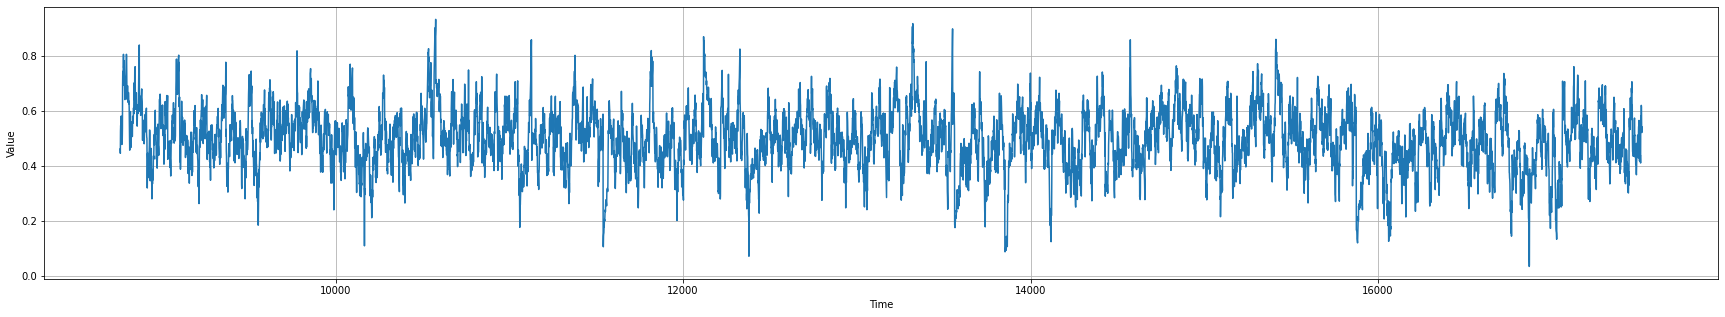

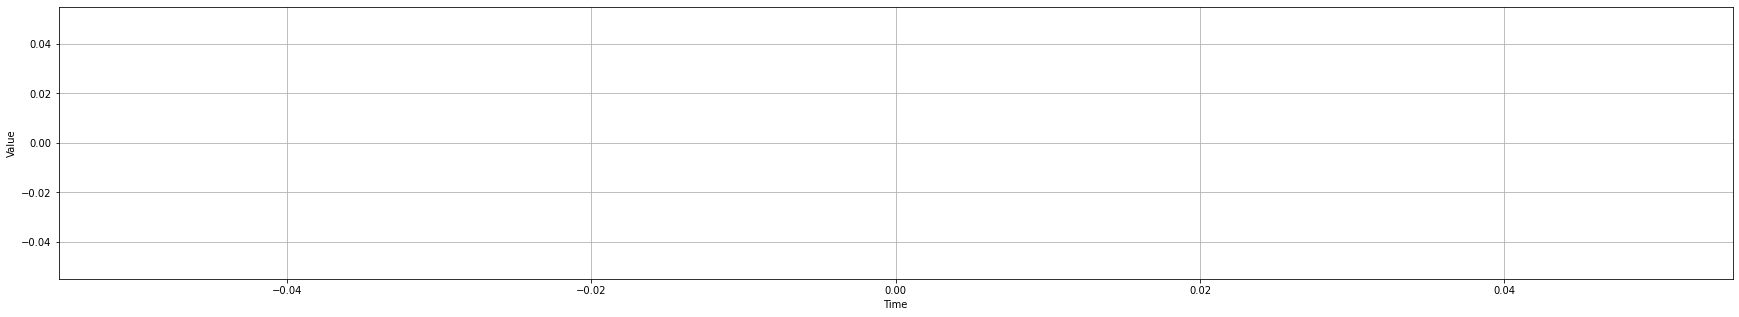

In [15]:
forecast = []

for t in range(len(data) - window_size):
    predict = model.predict(data[t:t + window_size][np.newaxis])
    forecast.append(predict)

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

nan